In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import csv
import copy

In [2]:
def color_segment(img):
    #segmentacja czerwonego
    lower_red = np.uint8(([70, 0, 0]))
    upper_red = np.uint8(([255, 70, 70]))

    red = inRange(img,lower_red,upper_red)

    #segmentacja zielonego
    lower_green = np.uint8(([0, 30, 0]))
    upper_green = np.uint8(([70, 255, 70]))

    green = inRange(img,lower_green,upper_green)

    #segmentacja niebieskiego
    lower_blue = np.uint8(([0, 0, 60]))
    upper_blue = np.uint8(([50, 50, 255]))

    blue = inRange(img,lower_blue,upper_blue)

    #segmentacja pomarańczowego
    lower_orange = np.uint8(([150, 60, 0]))
    upper_orange = np.uint8(([255, 255, 70]))
    
    orange = inRange(img,lower_orange,upper_orange)
    
    #segmentacja białego
    lower_white = np.uint8(([120, 120, 120]))
    upper_white = np.uint8(([255, 255, 255]))

    white = inRange(img,lower_white,upper_white)    
    return (red,green,blue,orange, white)

#znalezienie obiektów

def findobj(img, x, y, obj_list):
    
    h, w = img.shape
    obj_list.append([y,x])
    n = 0
    while n+1<=len(obj_list):
      #  print(len(obj_list))
      #  print('while')
        x = obj_list[n][1]
        y = obj_list[n][0]
      #  print(y,x)
        for xx in [-1, 0, 1]:
            for yy in [-1, 0, 1]:
                if y+yy<h and y+yy>=0 and x+xx>=0 and x+xx<w:
                    if img[y+yy,x+xx]==255 and not [y+yy,x+xx] in obj_list:
                        obj_list.append([y+yy,x+xx])
        n=n+1
    
def findobjects(img):
    obj = list()
   # plt.imshow(img)
    for y in range(0,img.shape[0]-1):
        for x in range(0,img.shape[1]-1): 
            if img[y,x]==255:
               # print(y,x)
                s=False
                for o in obj:
                    st = [y,x] in o
                    if st:
                        s = st
                if s==False: #Jeśli dany piksel nie występował w żadnym obiekcie do tej pory
                    new_obj = list()
                    findobj(img,x,y,new_obj)
                    obj.append(new_obj)
    return obj
def mpq(img,p,q):
    h, w = img.shape
    m = 0
    for i in range(0,h):
        for j in range(0,w):
            m = m + i**p*j**q*img[i][j]/255
    return m

def Mpq (img,p,q):
    h, w = img.shape
    M = 0
    ii = mpq(img,1,0)/mpq(img,0,0)
    jj = mpq(img,0,1)/mpq(img,0,0)
    for i in range(0,h):
        for j in range(0,w):
            M = M + (i-ii)**p*(j-jj)**q*img[i][j]/255
    return M

def moments(obj_list, img):
    l = len(obj_list)
    mom = list()
    img1 = np.zeros(img.shape)
    for o in obj_list:
        if len(o)<img.size/7:
            img1 = np.zeros(img.shape)
            m_i = list()
            obw = 0
            for y in range(1,img.shape[0]-1):
                for x in range(1,img.shape[1]-1): 
                    if [y,x] in o:
                        img1[y,x] = 255
                        if img1[y-1,x]==0 or img1[y+1,x]==0 or img1[y,x-1]==0 or img1[y,x+1]==0:
                            obw = obw + 1
            m_i.append((Mpq(img1,2,0)+Mpq(img1,0,2))/mpq(img1,0,0)**2) #M1
            m_i.append(((Mpq(img1,2,0) - Mpq(img1,0,2))**2+4*Mpq(img1,1,1)**2)/mpq(img1,0,0)**4) #M2
            m_i.append(((Mpq(img1,3,0) - 3 * Mpq(img1,1,2))**2+(3*Mpq(img1,2,1) - Mpq(img1,0,3))**2)/mpq(img1,0,0)**5) #M3
            m_i.append(((Mpq(img1,3,0) + Mpq(img1,1,2))**2+(Mpq(img1,2,1) + Mpq(img1,0,3))**2)/mpq(img1,0,0)**5) #M4
            m_i.append((Mpq(img1,2,0)*Mpq(img1,0,2) - Mpq(img1,1,1)**2)/mpq(img1,0,0)**4) #M7
            m_i.append(2*math.sqrt(mpq(img1,0,0)/math.pi)) #W1
            m_i.append(obw/math.pi) #W2
            mom.append(m_i)      
        else:
            mom.append([])
            
    return mom

def findcorners(obj):
    objarray = np.array(obj)
    [maxY,maxX] = objarray.max(0)
    [minY,minX] = objarray.min(0)
    return[(minX,minY),(maxX,minY),(maxX,maxY),(minX,maxY)]
def erosion(img,k):
    img1 = img
    h, w = img.shape
    imgE = np.zeros((h,w), np.uint8)
    for j in range(k):
        for x in range(2,h-2):
            for y in range(2,w-2):
                if img1[x,y]==255:
                    a=255
                    for xx in [-2,-1,1,2]:
                        for yy in [-2,-1,1,2]:
                            if img1[x+xx,y+yy] == 0:
                                a=0
                    imgE[x,y]=a
                            
        img1 = copy.deepcopy(imgE)             
    return imgE
def erosion1(img,k):
    img1 = img
    h, w = img.shape
    imgE = np.zeros((h,w), np.uint8)
    for j in range(k):
        for x in range(2,h-2):
            for y in range(2,w-2):
                if img1[x,y]==255:
                    a=255
                    for xx in [-1,1]:
                        for yy in [-1,1]:
                            if img1[x+xx,y+yy] == 0:
                                a=0
                    imgE[x,y]=a
                            
        img1 = copy.deepcopy(imgE)             
    return imgE
def dilation(img,k):
    img1 = img
    h, w = img.shape
    imgD = np.zeros((h,w), np.uint8)
    for j in range(k):

        for x in range(2,h-2):
            for y in range(2,w-2):
                if img1[x,y]==255:
                    for xx in [-2,-1,0,1,2]:
                        for yy in [-2,-1,0,1,2]:
                            imgD[x+xx,y+yy] = 255 
        
        img1 = copy.deepcopy(imgD)
                
    return imgD

def dilation1(img,k):
    img1 = img
    h, w = img.shape
    imgD = np.zeros((h,w), np.uint8)
    for j in range(k):

        for x in range(2,h-2):
            for y in range(2,w-2):
                if img1[x,y]==255:
                    for xx in [-1,0,1]:
                        for yy in [-1,0,1]:
                            imgD[x+xx,y+yy] = 255 
        
        img1 = copy.deepcopy(imgD)
                
    return imgD
def imgTr(img):
    h,w = img.shape
    imgTr = np.zeros((h,w), np.uint8)
    for x in range(h):
        for y in range(w):
                if img[x,y]>0:
                    imgTr[x, y] = 255
                else:
                    imgTr[x, y] = 0
    return imgTr

def inRange(img, lower, upper):
    h, w, c= img.shape
    img1 = np.zeros((h,w), np.uint8)
    for x in range(h):
        for y in range(w):
                if img[x,y,0]>=lower[0] and img[x,y,0]<=upper[0] and img[x,y,1]>=lower[1] and img[x,y,1]<=upper[1] and img[x,y,2]>=lower[2] and img[x,y,2]<=upper[2]:
                    img1[x, y] = 255
                else:
                    img1[x, y] = 0
    return img1

Wykonano segmentację kolorów
znaleziono obiekty czerwone
znaleziono obiekty zielone
policzono momenty dla obiektów czerwonych
policzono momenty dla obiektów zielonych
[246, 462, 54, 462]
znaleziono obiekty białe
policzono momenty dla obiektów białych
Znaleziono "K"
Znaleziono "N"


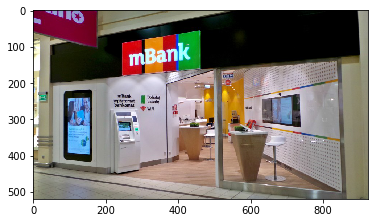

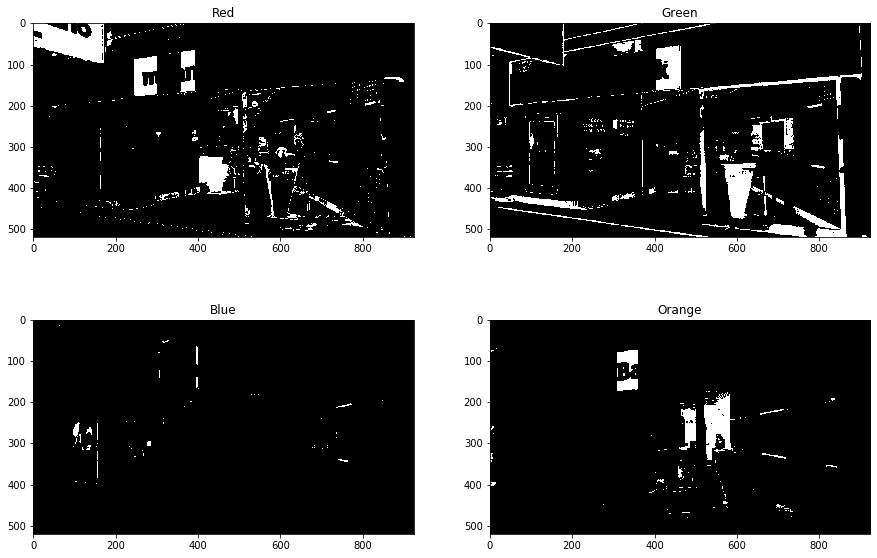

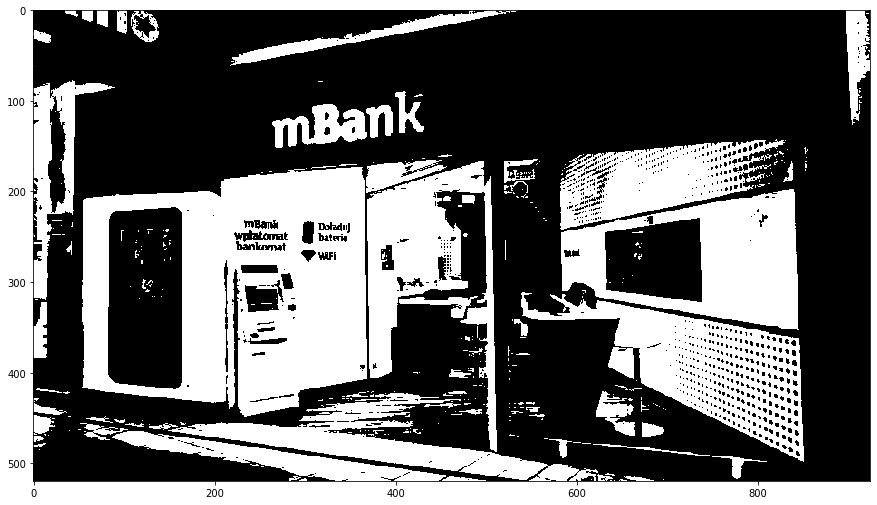

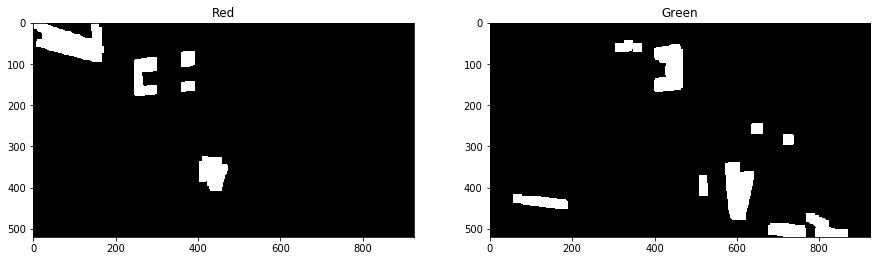

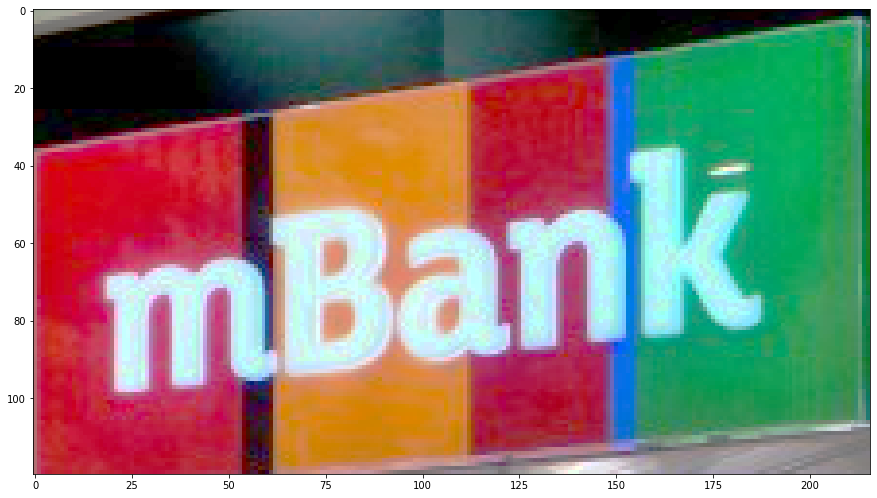

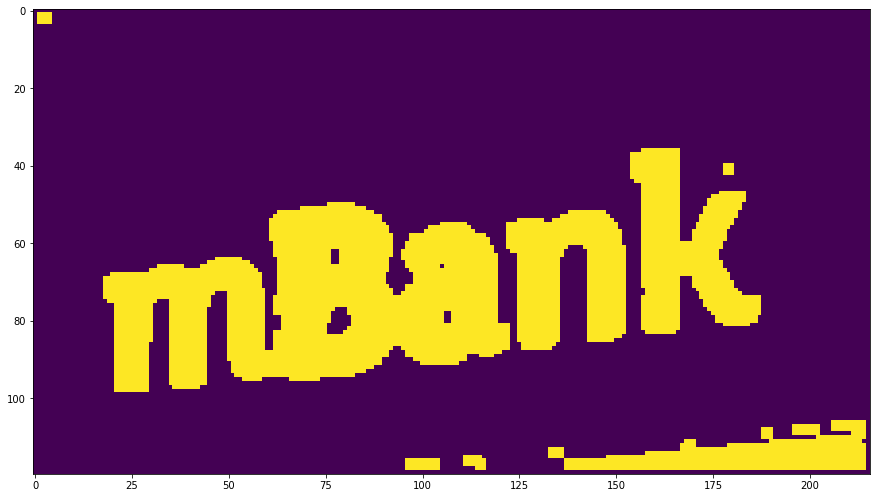

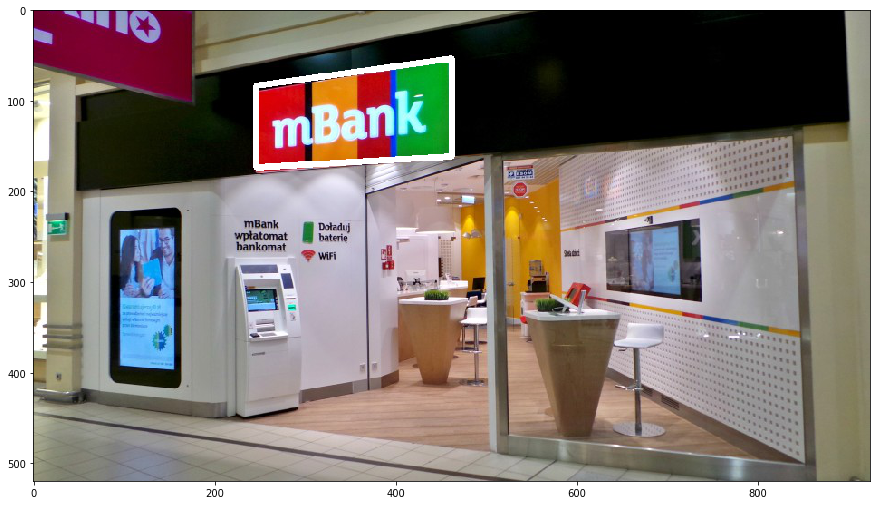

In [11]:
nazwa = 'mbank1.jpg' #'mbank1.jpg',,'mbank3.jpg'

img = cv2.imread(nazwa)
img = cv2.cvtColor(img,cv2.COLOR_RGB2BGR)
plt.imshow(img)

# wyrównanie histogramu
hist,bins = np.histogram(img.flatten(),256,[0,256])
cdf = hist.cumsum()
cdf_m = np.ma.masked_equal(cdf,0)
cdf_m = (cdf_m - cdf_m.min())*255/(cdf_m.max()-cdf_m.min())
cdf = np.ma.filled(cdf_m,0).astype('uint8')
image = cdf[img]

red,green,blue,orange,white = color_segment(image)
print('Wykonano segmentację kolorów')
fig,axis = plt.subplots(2,2,figsize=(15,10))
axis[0,0].imshow(red, cmap = 'gray')
axis[0,0].set_title('Red')
axis[0,1].imshow(green, cmap = 'gray')
axis[0,1].set_title('Green')
axis[1,0].imshow(blue, cmap = 'gray')
axis[1,0].set_title('Blue')
axis[1,1].imshow(orange, cmap = 'gray')
axis[1,1].set_title('Orange')
plt.figure(figsize = (15,10))
plt.imshow(white,cmap='gray')

kernel = np.ones([5,5],np.uint8)
kernel1 = np.ones([3,3],np.uint8)
kernel2 = np.array([[0,1,0],[1,1,1],[0,1,0]],np.uint8)

red1 = erosion(red,3)
green1 = erosion(green,3)

red1 = dilation(red1,3)
green1 = dilation(green1,5)

fig,axis = plt.subplots(1,2,figsize=(15,10))
axis[0].imshow(red1, cmap = 'gray')
axis[0].set_title('Red')
axis[1].imshow(green1, cmap = 'gray')
axis[1].set_title('Green')


red1resized = cv2.resize(red1, (round(red1.shape[1]/6), round(red1.shape[0]/6)))
green1resized = cv2.resize(green1, (round(green1.shape[1]/6), round(green1.shape[0]/6)))
red1resized = imgTr(red1resized)
green1resized = imgTr(green1resized)

objred = findobjects(red1resized)
print('znaleziono obiekty czerwone')
objgreen = findobjects(green1resized)
print('znaleziono obiekty zielone')
#objorange = findobjects(orange1)
#objwhite = findobjects(white1)

redmoments = moments(objred,red1resized)
print('policzono momenty dla obiektów czerwonych')
greenmoments = moments(objgreen,green1resized)
print('policzono momenty dla obiektów zielonych')
#orangemoments = moments(objorange,orange1)
#whitemoments = moments(objwhite,white1)
'''
with open('red_moments.csv', 'a') as redfile:
    redfile = csv.writer(redfile, delimiter=';', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    redfile.writerow(nazwa)
    for mm in redmoments:
        redfile.writerow(mm)

with open('green_moments.csv', 'a') as greenfile:
    greenfile = csv.writer(greenfile, delimiter=';', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    greenfile.writerow(nazwa)
    for mm in greenmoments:
        greenfile.writerow(mm)
'''
redsq = np.zeros([len(redmoments),1])
for i, rm in enumerate(redmoments):
    if rm[0]>0.2 and rm[0]<0.30 and rm[1]>0.01 and rm[1]<0.03 and rm[4]>0.01 and rm[4]<0.015:
        redsq[i] = 1
greensq = np.zeros([len(greenmoments),1])
for i, gm in enumerate(greenmoments):
    if gm[0]>0.21 and gm[0]<0.25 and gm[1]>0.012 and gm[1]<0.018 and gm[4]>0.008 and gm[4]<0.011:
        greensq[i] = 1

cred = []
cgreen = []
for i,obj in enumerate(objred):
    if redsq[i]==1:
        cred.append(findcorners(obj))

for j,obj in enumerate(objgreen):
    if greensq[j]==1:
        cgreen.append(findcorners(obj))                 
ccc=[] # lista rogów regionów zainteresowania
crg=[]
for cr in cred:
    for cg in cgreen:
        crg.append(cr+cg)
        crg1 = cr+cg
        carray = np.array(crg1)
        [minX,minY] = carray.min(0)
        [maxX,maxY] = carray.max(0)
        print([minX*6,maxX*6,minY*6,maxX*6])
        ccc.append([minX*6,maxX*6,minY*6,maxY*6])
frags = []
for k, c in enumerate(ccc):
    plt.figure(figsize=(15,10))
    frag1 = img[c[2]:c[3],c[0]:c[1],:]
    hist,bins = np.histogram(frag1.flatten(),256,[0,256])
    cdf = hist.cumsum()
    cdf_m = np.ma.masked_equal(cdf,0)
    cdf_m = (cdf_m - cdf_m.min())*255/(cdf_m.max()-cdf_m.min())
    cdf = np.ma.filled(cdf_m,0).astype('uint8')
    frag1 = cdf[frag1]
    plt.imshow(frag1)
    frags.append(frag1)
    red,green,blue,orange,white = color_segment(frag1)
    kernel1 = np.ones([3,3],np.uint8)
    white1 = erosion1(white,1)
    white1 = dilation1(white1,1)

    plt.figure(figsize=(15,10))
    plt.imshow(white1)

    objwhite = findobjects(white1)
    print('znaleziono obiekty białe')

    whitemoments = moments(objwhite,white1)
    print('policzono momenty dla obiektów białych')
    '''
    with open('white_moments.csv', 'a') as whitefile:
        whitefile = csv.writer(whitefile, delimiter=';', quotechar='"', quoting=csv.QUOTE_MINIMAL)
        whitefile.writerow(nazwa)
        for mm in whitemoments:
            whitefile.writerow(mm)
    '''
    znalezione = []
    lewy = []
    letters = np.zeros([len(whitemoments),1])
    for i, wm in enumerate(whitemoments):
        if wm != []:
            if wm[0]>0.28 and wm[0]<0.36 and wm[1]>0.015 and wm[1]<0.027 and wm[4]>0.015 and wm[4]<0.026 and wm[5]>20 and wm[6]>100:
                letters[i] = 1
                znalezione.append('M')
                lewy.append(min(objwhite[i])[1])
                print('Znaleziono "M"')
            if wm[0]>0.19 and wm[0]<0.28 and wm[1]>0.003 and wm[1]<0.009 and wm[4]>0.009 and wm[4]<0.018 and wm[5]>20 and wm[6]>100:
                letters[i] = 1
                znalezione.append('B') 
                lewy.append(min(objwhite[i])[1])
                print('Znaleziono "B"')
            if wm[0]>0.19 and wm[0]<0.28 and wm[1]>0.001 and wm[1]<0.008 and wm[4]>0.009 and wm[4]<0.018 and wm[5]>20 and wm[6]>100:
                letters[i] = 1
                znalezione.append('A') 
                lewy.append(min(objwhite[i])[1])
                print('Znaleziono "A"')
            if wm[0]>0.23 and wm[0]<0.31 and wm[1]>0.0005 and wm[1]<0.0012 and wm[4]>0.013 and wm[4]<0.023 and wm[5]>20 and wm[6]>100:
                letters[i] = 1
                znalezione.append('N') 
                lewy.append(min(objwhite[i])[1])
                print('Znaleziono "N"')
            if wm[0]>0.24 and wm[0]<0.31 and wm[1]>0.01 and wm[1]<0.03 and wm[4]>0.011 and wm[4]<0.017 and wm[5]>20 and wm[6]>100:
                letters[i] = 1
                znalezione.append('K') 
                lewy.append(min(objwhite[i])[1])
                print('Znaleziono "K"')
    data = {"litera": znalezione, "kolejnosc":lewy}
    df = pd.DataFrame(data)
    df.sort_values(["kolejnosc",'litera'], axis = 0, ascending = [True,True], inplace = True)
    df.reset_index(inplace=True)
    ok1 = 0
    for s, l in enumerate(df.litera):
        for g, li in enumerate(df.litera[s+1:]):
            if (l+li) in "MBANK":
                ok1 = ok1 + 1
    df.sort_values(["kolejnosc",'litera'], axis = 0, ascending = [True,False], inplace = True)
    df.reset_index(inplace=True)
    ok2 = 0
    for s, l in enumerate(df.litera):
        if s<df.litera.size-1:
            if (l+df.litera[s+1]) in "MBANK":
                ok2 = ok2 + 1
    ok = max([ok1,ok2])
    if sum(letters)>=2 and ok>0:
        cv2.line(img,tuple([crg[k][5][0]*6,crg[k][5][1]*6]),tuple([crg[k][6][0]*6,crg[k][6][1]*6]),(255, 255, 255),5)
        cv2.line(img,tuple([crg[k][0][0]*6,crg[k][0][1]*6]),tuple([crg[k][5][0]*6,crg[k][5][1]*6]),(255, 255, 255),5) #ok
        cv2.line(img,tuple([crg[k][0][0]*6,crg[k][0][1]*6]),tuple([crg[k][3][0]*6,crg[k][3][1]*6]),(255, 255, 255),5) #ok
        cv2.line(img,tuple([crg[k][3][0]*6,crg[k][3][1]*6]),tuple([crg[k][6][0]*6,crg[k][6][1]*6]),(255, 255, 255),5) #ok
plt.figure(figsize=(15,10))
plt.imshow(img)

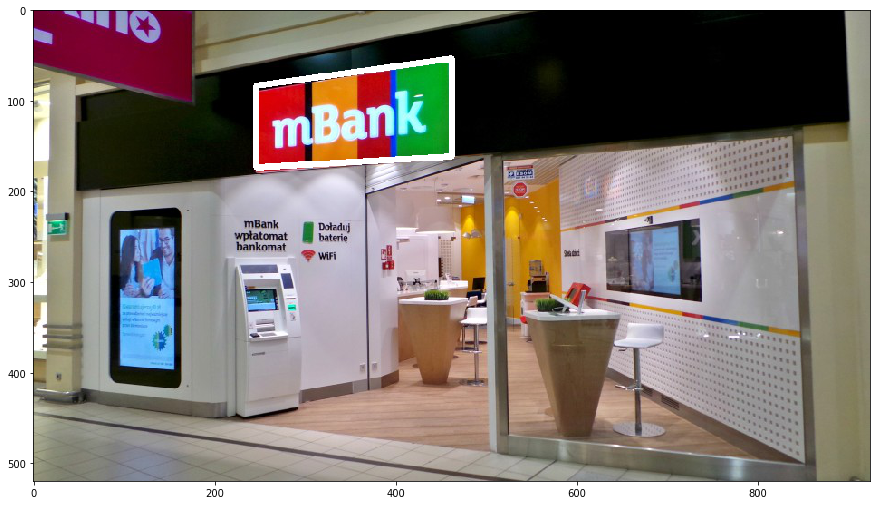

In [153]:
plt.figure(figsize=(15,10))
plt.imshow(img)